In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import time
from datetime import datetime
import os
from tensorflow.keras.layers import (Dense, Reshape, Flatten, 
                                    LayerNormalization, Activation, 
                                    LeakyReLU, Conv2D, Conv2DTranspose)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10

In [ ]:
# Set up TensorBoard
log_dir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir)

(X, y), (_, _) = cifar10.load_data()
X = X[y.flatten() == 8]  # Class 8: ships
X = (X.astype('float32') / 127.5) - 1.0  

# Model parameters
image_shape = (32, 32, 3)
latent_dim = 100
n_critic = 3
gp_weight = 10

In [ ]:
# Fixed Generator
def build_generator():
    return Sequential([
        Dense(512 * 8 * 8, activation='relu', input_dim=latent_dim),
        Reshape((8, 8, 512)),
        Conv2DTranspose(256, 4, strides=2, padding='same'),
        LayerNormalization(),
        Activation('relu'),
        
        Conv2DTranspose(128, 4, strides=2, padding='same'),
        LayerNormalization(),
        Activation('relu'),
        
        Conv2DTranspose(64, 4, strides=1, padding='same'),
        LayerNormalization(),
        Activation('relu'),
        
        Conv2D(3, 3, padding='same', activation='tanh', dtype='float32')
    ])
    
def build_critic():
    return Sequential([
        Conv2D(64, 3, strides=2, padding='same', input_shape=image_shape),
        LeakyReLU(0.2),
        
        Conv2D(128, 3, strides=2, padding='same'),
        LayerNormalization(),
        LeakyReLU(0.2),
        
        Conv2D(256, 3, strides=2, padding='same'),
        LayerNormalization(),
        LeakyReLU(0.2),
        
        Flatten(),
        Dense(1)
    ])

#Wasserstein GAN class
class WGANGP(tf.keras.Model):
    def __init__(self, critic, generator, latent_dim, gp_weight):
        super().__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.gp_weight = gp_weight

    def gradient_penalty(self, real_images, fake_images):
        alpha = tf.random.uniform([len(real_images), 1, 1, 1], 0., 1.)
        interpolated = alpha * real_images + (1 - alpha) * fake_images

        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.critic(interpolated)
        
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # Train critic
        for _ in range(n_critic):
            noise = tf.random.normal([batch_size, self.latent_dim])
            with tf.GradientTape() as tape:
                fake_images = self.generator(noise)
                real_pred = self.critic(real_images)
                fake_pred = self.critic(fake_images)
                gp = self.gradient_penalty(real_images, fake_images)
                c_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + gp * self.gp_weight

            c_grads = tape.gradient(c_loss, self.critic.trainable_weights)
            self.optimizer_critic.apply_gradients(zip(c_grads, self.critic.trainable_weights))

        # Train generator
        noise = tf.random.normal([batch_size, self.latent_dim])
        with tf.GradientTape() as tape:
            fake_images = self.generator(noise)
            fake_pred = self.critic(fake_images)
            g_loss = -tf.reduce_mean(fake_pred)

        g_grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.optimizer_generator.apply_gradients(zip(g_grads, self.generator.trainable_weights))

        return {'c_loss': c_loss, 'g_loss': g_loss}


# Initialize models and optimizers
generator = build_generator()
critic = build_critic()

optimizer_generator = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
optimizer_critic = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

wgan_gp = WGANGP(critic=critic, generator=generator, 
                latent_dim=latent_dim, gp_weight=gp_weight)

wgan_gp.optimizer_generator = optimizer_generator
wgan_gp.optimizer_critic = optimizer_critic

# Training parameters
batch_size = 512
epochs = 5000
display_interval = 500
print_interval = 50

dataset = (tf.data.Dataset.from_tensor_slices(X)
           .shuffle(2000, reshuffle_each_iteration=True)
           .batch(batch_size, drop_remainder=True)
           .prefetch(tf.data.AUTOTUNE))

# Enable XLA Compilation
tf.config.optimizer.set_jit(True)

In [2]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097408   
 nspose)                                                         
                                                                 
 layer_normalization (LayerN  (None, 16, 16, 256)      512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      5

In [3]:
critic.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 layer_normalization_3 (Laye  (None, 8, 8, 128)        256       
 rNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         295168    
                                                      

Epoch 0, Elapsed Time: 0.10 minutes
Critic Loss: -10.4695, Generator Loss: 10.4561



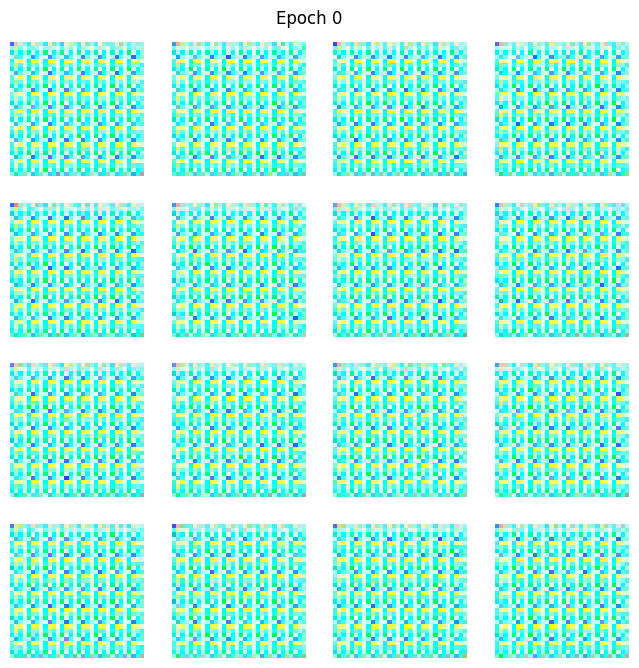

Epoch 50, Elapsed Time: 4.84 minutes
Critic Loss: -3.0055, Generator Loss: 8.4138

Epoch 100, Elapsed Time: 9.62 minutes
Critic Loss: -4.7099, Generator Loss: -21.1649

Epoch 150, Elapsed Time: 14.39 minutes
Critic Loss: -0.2238, Generator Loss: -24.6977

Epoch 200, Elapsed Time: 19.22 minutes
Critic Loss: -8.6809, Generator Loss: -22.3758

Epoch 250, Elapsed Time: 24.02 minutes
Critic Loss: 0.1783, Generator Loss: -9.6541

Epoch 300, Elapsed Time: 28.78 minutes
Critic Loss: 1.9026, Generator Loss: -47.1890

Epoch 350, Elapsed Time: 33.44 minutes
Critic Loss: -2.2046, Generator Loss: -27.7699

Epoch 400, Elapsed Time: 38.15 minutes
Critic Loss: -3.4943, Generator Loss: -35.1963

Epoch 450, Elapsed Time: 42.84 minutes
Critic Loss: -2.3667, Generator Loss: -41.5292

Epoch 500, Elapsed Time: 47.51 minutes
Critic Loss: -2.8856, Generator Loss: -46.6153



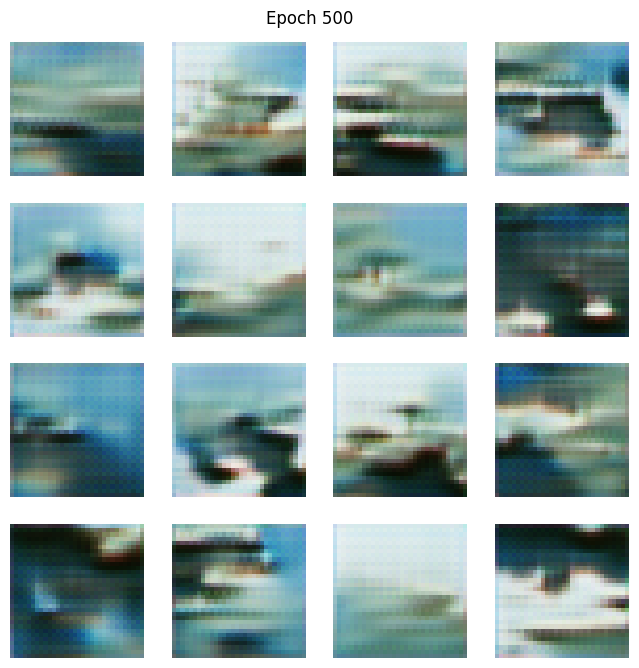

Epoch 550, Elapsed Time: 52.19 minutes
Critic Loss: -2.9009, Generator Loss: -29.9731

Epoch 600, Elapsed Time: 56.85 minutes
Critic Loss: -2.3866, Generator Loss: -66.8160

Epoch 650, Elapsed Time: 61.52 minutes
Critic Loss: -0.6957, Generator Loss: -80.3273

Epoch 700, Elapsed Time: 66.19 minutes
Critic Loss: -0.8239, Generator Loss: -75.8862

Epoch 750, Elapsed Time: 70.85 minutes
Critic Loss: -0.4669, Generator Loss: -78.3424

Epoch 800, Elapsed Time: 75.52 minutes
Critic Loss: -2.6129, Generator Loss: -49.4315

Epoch 850, Elapsed Time: 80.20 minutes
Critic Loss: -2.9048, Generator Loss: -48.0514

Epoch 900, Elapsed Time: 84.87 minutes
Critic Loss: 1.0217, Generator Loss: -76.8612

Epoch 950, Elapsed Time: 89.54 minutes
Critic Loss: -2.0787, Generator Loss: -68.3492

Epoch 1000, Elapsed Time: 94.22 minutes
Critic Loss: -3.0860, Generator Loss: -87.4027



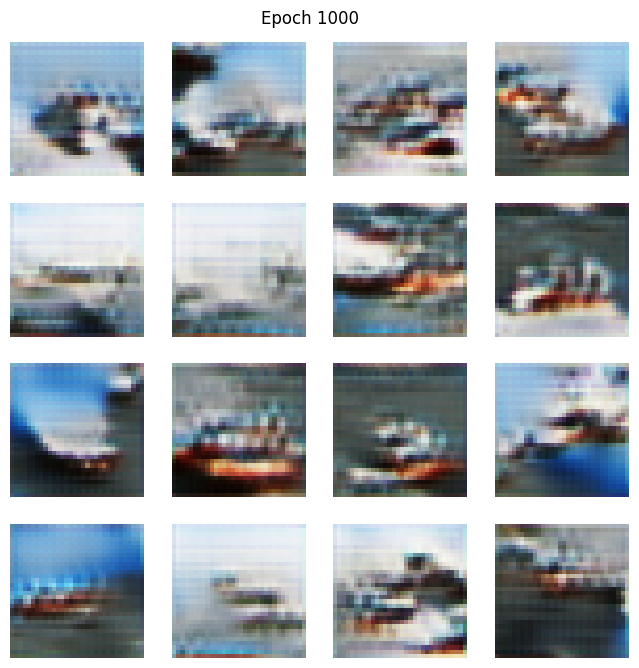

Epoch 1050, Elapsed Time: 98.89 minutes
Critic Loss: -1.6862, Generator Loss: -101.5063

Epoch 1100, Elapsed Time: 103.56 minutes
Critic Loss: -0.7328, Generator Loss: -83.9584

Epoch 1150, Elapsed Time: 108.24 minutes
Critic Loss: -2.0212, Generator Loss: -94.2271

Epoch 1200, Elapsed Time: 112.94 minutes
Critic Loss: -1.1421, Generator Loss: -111.4291

Epoch 1250, Elapsed Time: 117.64 minutes
Critic Loss: -2.9541, Generator Loss: -103.0689

Epoch 1300, Elapsed Time: 122.34 minutes
Critic Loss: -0.9977, Generator Loss: -101.4245

Epoch 1350, Elapsed Time: 127.03 minutes
Critic Loss: -0.4878, Generator Loss: -104.0682

Epoch 1400, Elapsed Time: 131.73 minutes
Critic Loss: -0.0534, Generator Loss: -88.1169

Epoch 1450, Elapsed Time: 136.42 minutes
Critic Loss: -2.4817, Generator Loss: -83.8951

Epoch 1500, Elapsed Time: 141.26 minutes
Critic Loss: -0.5547, Generator Loss: -133.2599



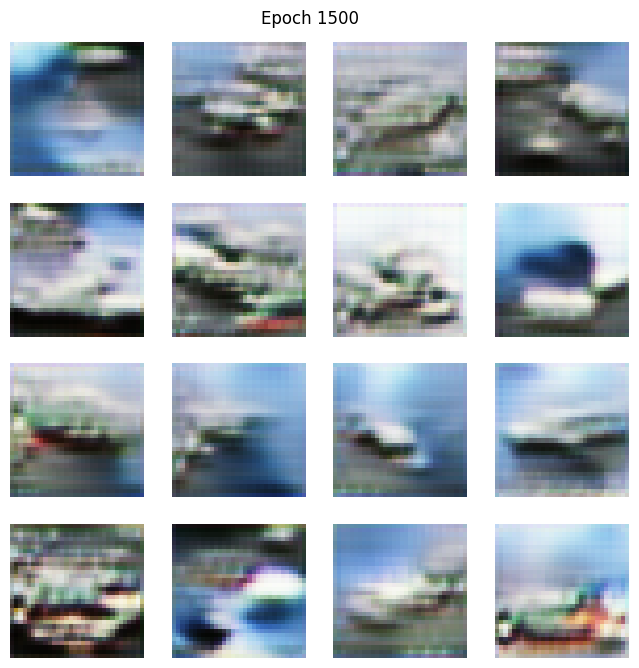

Epoch 1550, Elapsed Time: 145.92 minutes
Critic Loss: 0.6416, Generator Loss: -113.8354

Epoch 1600, Elapsed Time: 150.60 minutes
Critic Loss: -0.7647, Generator Loss: -117.7003

Epoch 1650, Elapsed Time: 155.30 minutes
Critic Loss: -0.6123, Generator Loss: -101.0814

Epoch 1700, Elapsed Time: 160.10 minutes
Critic Loss: 0.1409, Generator Loss: -111.1255

Epoch 1750, Elapsed Time: 164.78 minutes
Critic Loss: -1.6966, Generator Loss: -92.9274

Epoch 1800, Elapsed Time: 169.78 minutes
Critic Loss: 0.6079, Generator Loss: -109.5119

Epoch 1850, Elapsed Time: 174.50 minutes
Critic Loss: -1.6275, Generator Loss: -92.0294

Epoch 1900, Elapsed Time: 179.17 minutes
Critic Loss: -1.2602, Generator Loss: -97.5001

Epoch 1950, Elapsed Time: 183.88 minutes
Critic Loss: 0.9275, Generator Loss: -87.2412

Epoch 2000, Elapsed Time: 188.57 minutes
Critic Loss: -1.4504, Generator Loss: -116.8517



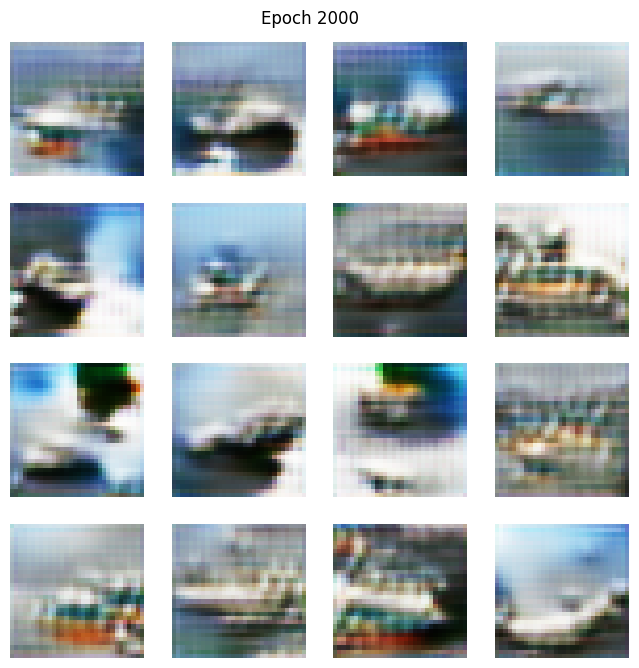

Epoch 2050, Elapsed Time: 193.24 minutes
Critic Loss: 1.2827, Generator Loss: -106.1219

Epoch 2100, Elapsed Time: 197.92 minutes
Critic Loss: -0.2839, Generator Loss: -104.3573

Epoch 2150, Elapsed Time: 202.59 minutes
Critic Loss: -2.8467, Generator Loss: -115.1756

Epoch 2200, Elapsed Time: 207.27 minutes
Critic Loss: -0.2432, Generator Loss: -94.6252

Epoch 2250, Elapsed Time: 211.95 minutes
Critic Loss: -0.3641, Generator Loss: -105.9427

Epoch 2300, Elapsed Time: 216.63 minutes
Critic Loss: -0.5192, Generator Loss: -119.8726

Epoch 2350, Elapsed Time: 221.38 minutes
Critic Loss: 1.2773, Generator Loss: -111.7409

Epoch 2400, Elapsed Time: 225.84 minutes
Critic Loss: -2.8762, Generator Loss: -101.5850

Epoch 2450, Elapsed Time: 230.27 minutes
Critic Loss: -0.9989, Generator Loss: -83.2946

Epoch 2500, Elapsed Time: 234.69 minutes
Critic Loss: -1.3407, Generator Loss: -90.6456



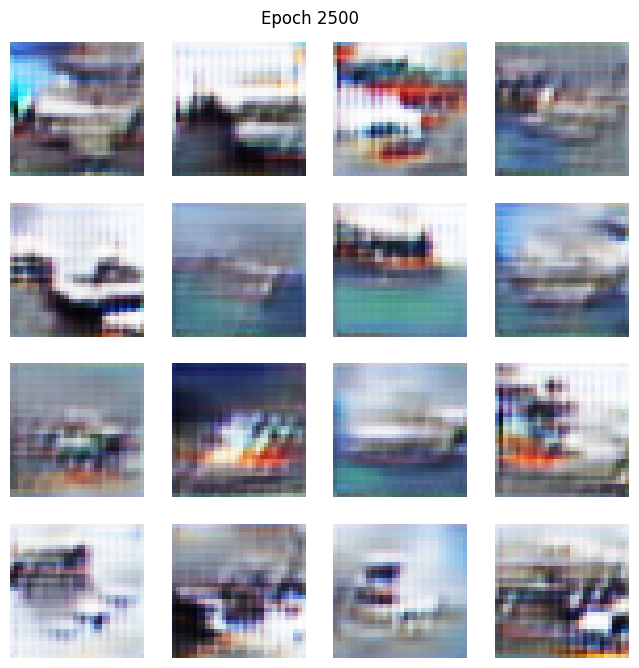

Epoch 2550, Elapsed Time: 239.12 minutes
Critic Loss: -0.4138, Generator Loss: -82.8428

Epoch 2600, Elapsed Time: 243.55 minutes
Critic Loss: -0.6252, Generator Loss: -96.0116

Epoch 2650, Elapsed Time: 247.98 minutes
Critic Loss: -0.1335, Generator Loss: -93.9301

Epoch 2700, Elapsed Time: 252.40 minutes
Critic Loss: -0.2254, Generator Loss: -124.2488

Epoch 2750, Elapsed Time: 256.83 minutes
Critic Loss: -1.9380, Generator Loss: -86.4356

Epoch 2800, Elapsed Time: 261.24 minutes
Critic Loss: -1.2840, Generator Loss: -95.0296

Epoch 2850, Elapsed Time: 265.67 minutes
Critic Loss: -2.5172, Generator Loss: -92.4463

Epoch 2900, Elapsed Time: 270.11 minutes
Critic Loss: -1.0000, Generator Loss: -90.7964

Epoch 2950, Elapsed Time: 274.53 minutes
Critic Loss: -0.6265, Generator Loss: -89.5645

Epoch 3000, Elapsed Time: 278.95 minutes
Critic Loss: 1.0559, Generator Loss: -123.0947



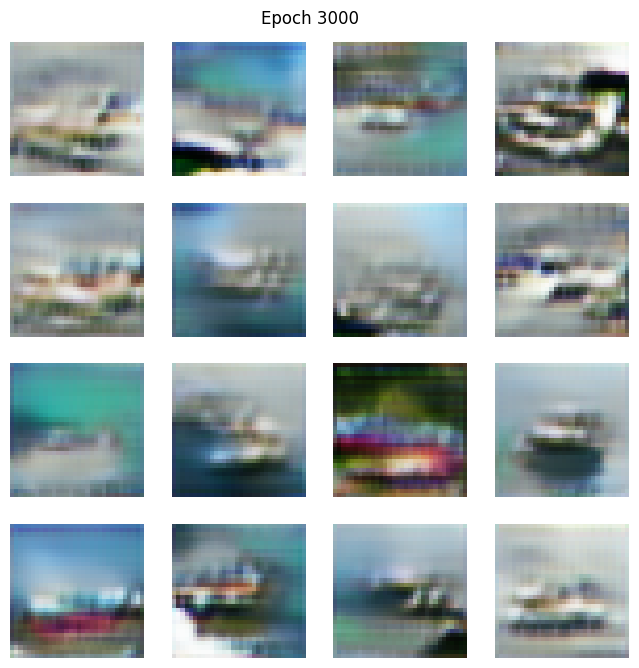

Epoch 3050, Elapsed Time: 283.36 minutes
Critic Loss: -0.0377, Generator Loss: -103.1326

Epoch 3100, Elapsed Time: 287.79 minutes
Critic Loss: -2.3787, Generator Loss: -138.6480

Epoch 3150, Elapsed Time: 292.21 minutes
Critic Loss: 0.9293, Generator Loss: -121.8461

Epoch 3200, Elapsed Time: 296.62 minutes
Critic Loss: -0.2405, Generator Loss: -104.4881

Epoch 3250, Elapsed Time: 301.04 minutes
Critic Loss: 0.1050, Generator Loss: -144.9072

Epoch 3300, Elapsed Time: 305.46 minutes
Critic Loss: 0.2913, Generator Loss: -138.8472

Epoch 3350, Elapsed Time: 309.87 minutes
Critic Loss: 0.3967, Generator Loss: -138.4370

Epoch 3400, Elapsed Time: 314.35 minutes
Critic Loss: -0.3098, Generator Loss: -124.7978

Epoch 3450, Elapsed Time: 318.99 minutes
Critic Loss: -0.7577, Generator Loss: -142.5035

Epoch 3500, Elapsed Time: 323.40 minutes
Critic Loss: -0.8796, Generator Loss: -128.3115



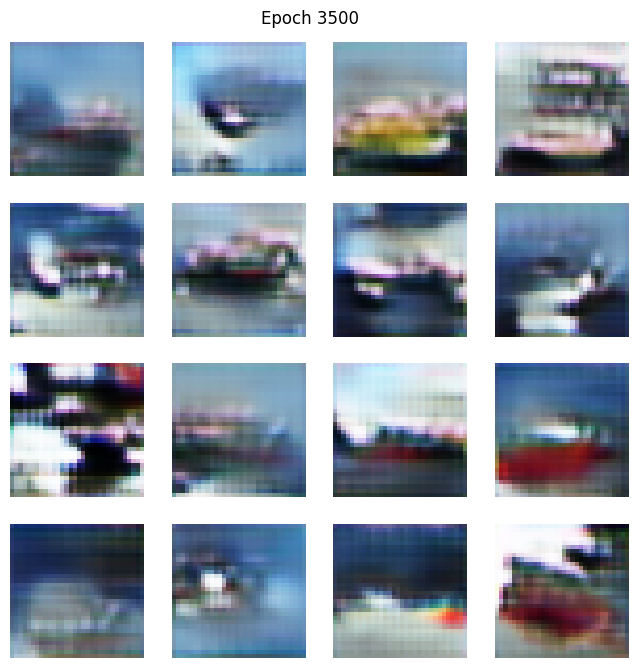

Epoch 3550, Elapsed Time: 327.81 minutes
Critic Loss: -0.8327, Generator Loss: -158.2119

Epoch 3600, Elapsed Time: 332.22 minutes
Critic Loss: 1.3983, Generator Loss: -139.6367

Epoch 3650, Elapsed Time: 336.63 minutes
Critic Loss: 0.3823, Generator Loss: -139.7626

Epoch 3700, Elapsed Time: 341.04 minutes
Critic Loss: -3.9702, Generator Loss: -141.3878

Epoch 3750, Elapsed Time: 345.45 minutes
Critic Loss: -1.5322, Generator Loss: -151.1662

Epoch 3800, Elapsed Time: 349.87 minutes
Critic Loss: -1.0753, Generator Loss: -157.2196

Epoch 3850, Elapsed Time: 354.29 minutes
Critic Loss: -1.0542, Generator Loss: -135.2744

Epoch 3900, Elapsed Time: 358.71 minutes
Critic Loss: -1.2597, Generator Loss: -163.3156

Epoch 3950, Elapsed Time: 363.13 minutes
Critic Loss: -1.2272, Generator Loss: -136.4874

Epoch 4000, Elapsed Time: 367.56 minutes
Critic Loss: -0.0388, Generator Loss: -146.6631



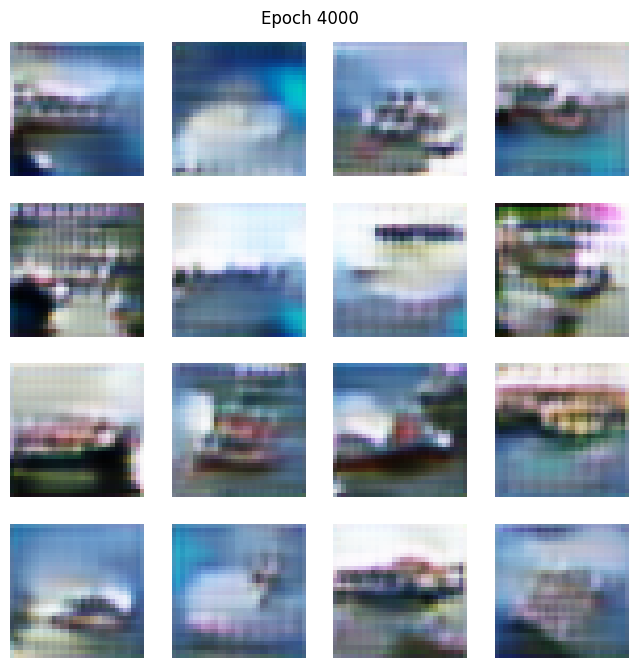

Epoch 4050, Elapsed Time: 371.98 minutes
Critic Loss: -0.0274, Generator Loss: -118.1918

Epoch 4100, Elapsed Time: 376.39 minutes
Critic Loss: 0.0596, Generator Loss: -144.4813

Epoch 4150, Elapsed Time: 380.78 minutes
Critic Loss: 0.2410, Generator Loss: -143.7430

Epoch 4200, Elapsed Time: 385.19 minutes
Critic Loss: -1.9212, Generator Loss: -143.3882

Epoch 4250, Elapsed Time: 389.62 minutes
Critic Loss: -0.3792, Generator Loss: -171.6543

Epoch 4300, Elapsed Time: 394.03 minutes
Critic Loss: -0.1552, Generator Loss: -158.3870

Epoch 4350, Elapsed Time: 398.44 minutes
Critic Loss: -0.1427, Generator Loss: -173.2941

Epoch 4400, Elapsed Time: 402.86 minutes
Critic Loss: -0.6099, Generator Loss: -162.2485

Epoch 4450, Elapsed Time: 407.26 minutes
Critic Loss: -0.6888, Generator Loss: -177.5602

Epoch 4500, Elapsed Time: 411.66 minutes
Critic Loss: -0.4532, Generator Loss: -151.4642



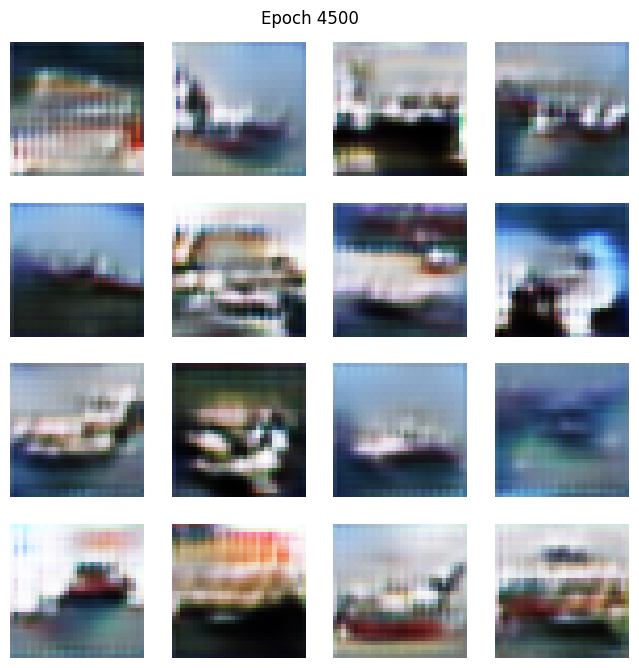

Epoch 4550, Elapsed Time: 416.07 minutes
Critic Loss: 0.2859, Generator Loss: -167.9144

Epoch 4600, Elapsed Time: 420.47 minutes
Critic Loss: -0.5389, Generator Loss: -177.2171

Epoch 4650, Elapsed Time: 424.88 minutes
Critic Loss: -0.0065, Generator Loss: -180.9638

Epoch 4700, Elapsed Time: 429.29 minutes
Critic Loss: 0.1559, Generator Loss: -190.9834

Epoch 4750, Elapsed Time: 433.70 minutes
Critic Loss: 1.2341, Generator Loss: -181.1840

Epoch 4800, Elapsed Time: 438.11 minutes
Critic Loss: -0.5967, Generator Loss: -190.6223

Epoch 4850, Elapsed Time: 442.52 minutes
Critic Loss: -0.5263, Generator Loss: -172.1025

Epoch 4900, Elapsed Time: 446.93 minutes
Critic Loss: -2.5464, Generator Loss: -155.9188

Epoch 4950, Elapsed Time: 451.34 minutes
Critic Loss: -1.7526, Generator Loss: -164.1850


Generating final images...


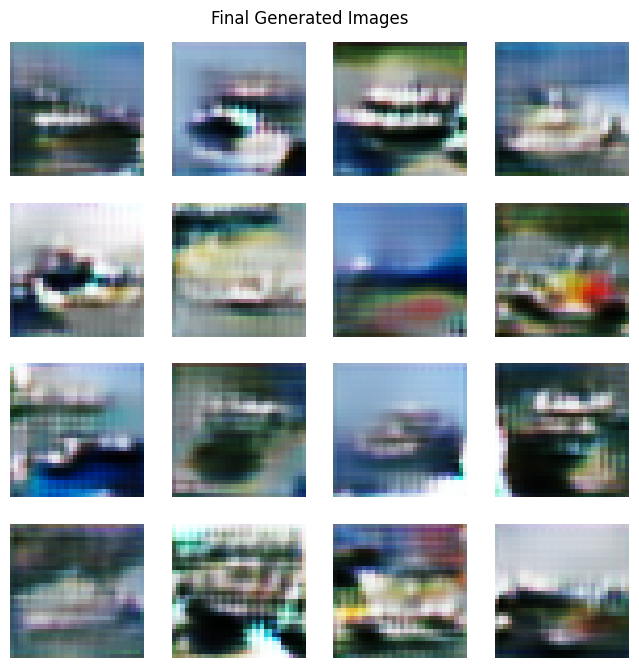

Training completed!


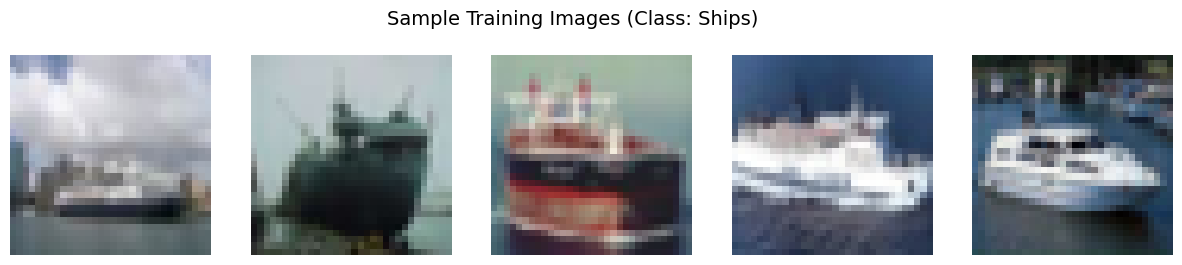

In [ ]:
start_time = time.time()  # Track start time
# Training loop with TensorBoard logging
for epoch in range(epochs):  
    epoch_start = time.time()  # Track epoch start time
    
    for batch in dataset:
        metrics = wgan_gp.train_step(batch)
    
    # Log metrics to TensorBoard
    with file_writer.as_default():
        tf.summary.scalar('Critic Loss', metrics['c_loss'], step=epoch)
        tf.summary.scalar('Generator Loss', metrics['g_loss'], step=epoch)
    
    if epoch % print_interval == 0:
        elapsed_time = time.time() - start_time  # Total elapsed time
        print(f"Epoch {epoch}, Elapsed Time: {elapsed_time/60:.2f} minutes")
        print(f"Critic Loss: {metrics['c_loss'].numpy():.4f}, Generator Loss: {metrics['g_loss'].numpy():.4f}\n")
    
    if epoch % display_interval == 0:
        noise = tf.random.normal([16, latent_dim])
        generated_images = generator(noise)
        generated_images = (generated_images * 0.5) + 0.5
        
        plt.figure(figsize=(8, 8))
        for i in range(16):
            plt.subplot(4, 4, i+1)
            plt.imshow(generated_images[i])
            plt.axis('off')
        plt.suptitle(f"Epoch {epoch}", y=0.92)
        plt.show()

# Generate final images after training
print("\nGenerating final images...")
noise = tf.random.normal([16, latent_dim])
final_images = generator(noise)
final_images = (final_images * 0.5) + 0.5

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(final_images[i])
    plt.axis('off')
plt.suptitle("Final Generated Images", y=0.92)
plt.show()

print("Training completed!")

def display_training_images():
    # Randomly select 5 images from the training data
    indices = np.random.randint(0, X.shape[0], 5)
    samples = X[indices]
    
    # Reverse preprocessing: convert from [-1, 1] to [0, 1]
    samples = (samples + 1) / 2.0
    
    # Create plot
    plt.figure(figsize=(15, 3))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(samples[i])
        plt.axis('off')
    plt.suptitle("Sample Training Images (Class: Ships)", fontsize=14)
    plt.show()

# Usage example
display_training_images()